# Continuous Control


### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='Reacher_single_agent.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


As explained in the Navigation notebook, environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. As mentioned in the instructions, a reward of `+0.1` is provided for each time step that the agent's hand is in the goal location. Thus, the goal of the agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


When finished, you can close the environment.

### 4. Implementation

 When training the environment, we set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:
# Import the plotting function
%matplotlib inline
from utils import plot_scores

### Instantiate the Agent

In [6]:
from  ddpg_gen_agent import Agent
agent = Agent(state_size=33, action_size=4, seed=234)

### Define the ddpg algorithm

In [7]:
from collections import deque
import numpy as np
import torch
def ddpg(n_episodes=500, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.999, attempt=None):
    """Deep DPG
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start: noise decay start
        eps_end: terminal noise decay
        eps_decay: decay rate per episode
        
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start
    attain_max = False
    low_bound = 30
    for i_episode in range(1, n_episodes+1):           
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0] 
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]        # send the action to the environment and brain
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]   # get the done status
            agent.step(state, action, reward, next_state, done) # Add to memory, and if enough steps, learn
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay * eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            # Add plots every 100 episodes
            plot_scores(scores, attempt, i_episode)
        if np.mean(scores_window)>=low_bound and attain_max==False:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.optim_actor.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.optim_critic.state_dict(), 'checkpoint_agent.pth')
            attain_max = True
            low_bound = np.mean(scores_window)
        elif np.mean(scores_window) > low_bound:
            print('\nMaxium average achieved after {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            torch.save(agent.optim_actor.state_dict(), 'checkpoint_actor_max.pth')
            torch.save(agent.optim_critic.state_dict(), 'checkpoint_agent_max.pth')
            low_bound = np.mean(scores_window)
    return scores





In [ ]:
# Attempt 22: 1000 episodes
scores = ddpg(1000, attempt=22)

Episode 51	Average Score: 0.61

Episode 100	Average Score: 1.21


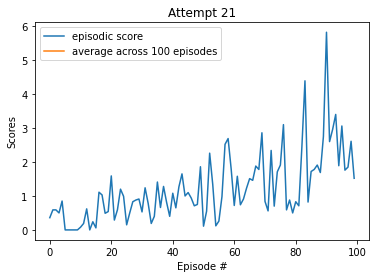

Episode 200	Average Score: 6.67


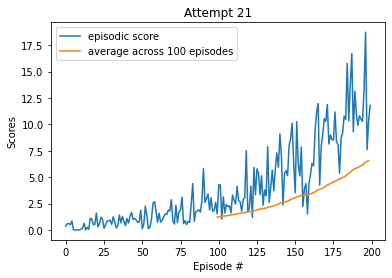

Episode 300	Average Score: 17.31


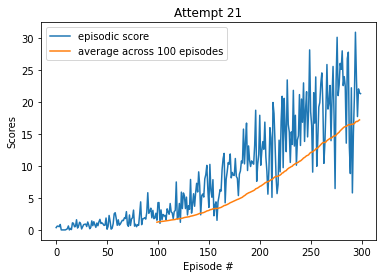

Episode 400	Average Score: 24.20


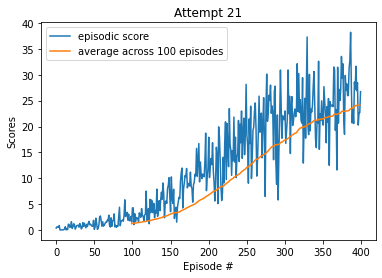

Episode 500	Average Score: 26.94


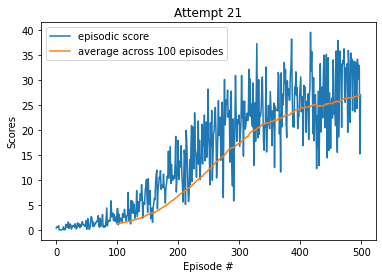

Episode 600	Average Score: 28.88


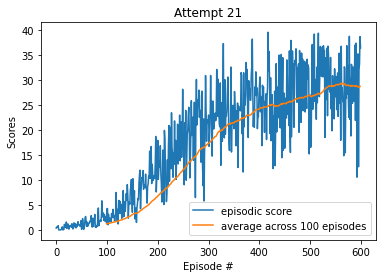

Episode 697	Average Score: 30.04
Environment solved in 597 episodes!	Average Score: 30.04
Episode 698	Average Score: 30.08
Maxium average achieved after 698 episodes!	Average Score: 30.08
Episode 699	Average Score: 30.06
Maxium average achieved after 699 episodes!	Average Score: 30.06
Episode 700	Average Score: 29.98


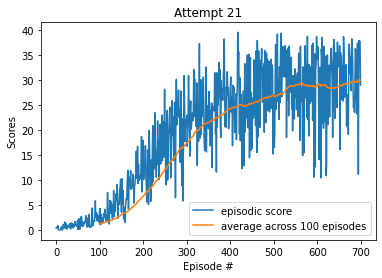

In [8]:
# Attempt 21: Same configuration
scores = ddpg(700, attempt=21)

Episode 100	Average Score: 0.91


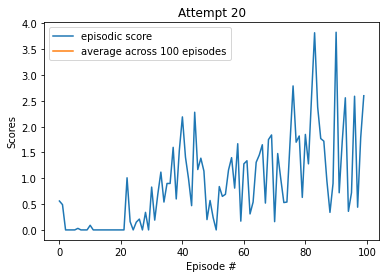

Episode 200	Average Score: 3.55


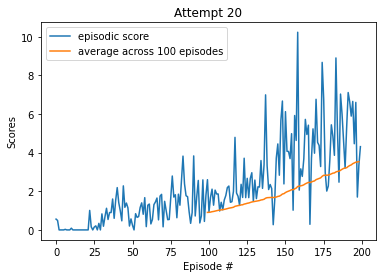

Episode 300	Average Score: 6.29


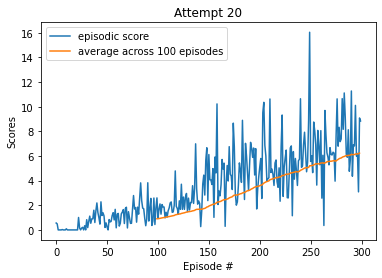

Episode 400	Average Score: 8.69


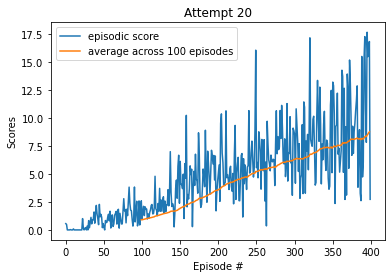

Episode 500	Average Score: 16.01


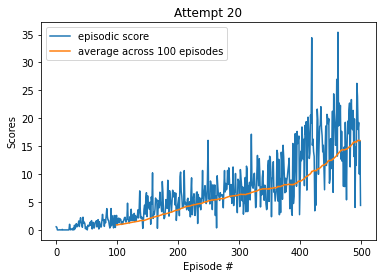

Episode 600	Average Score: 17.87


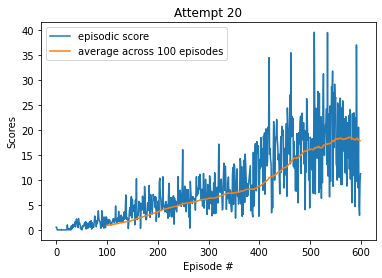

Episode 700	Average Score: 18.53


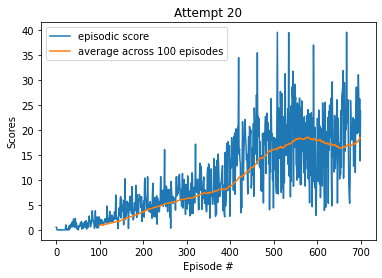

In [8]:
scores = ddpg(700, attempt=20)

Episode 100	Average Score: 0.99


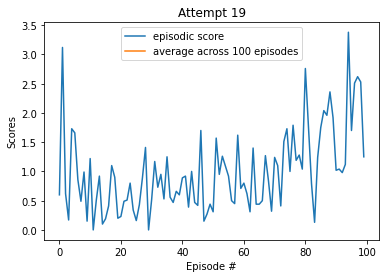

Episode 200	Average Score: 3.55


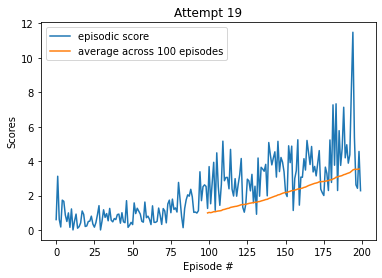

Episode 300	Average Score: 5.32


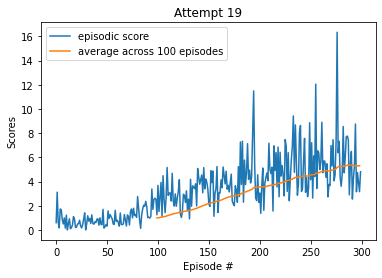

Episode 391	Average Score: 6.36

In [ ]:
# batch normalization
scores = ddpg(500, attempt=19)

Episode 100	Average Score: 1.47


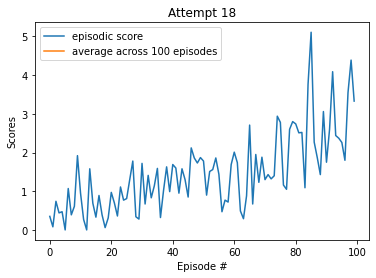

Episode 200	Average Score: 8.65


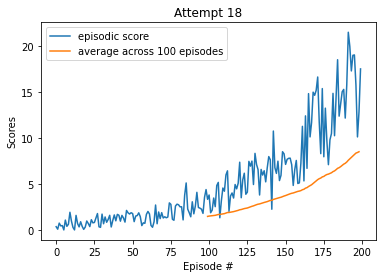

Episode 300	Average Score: 20.97


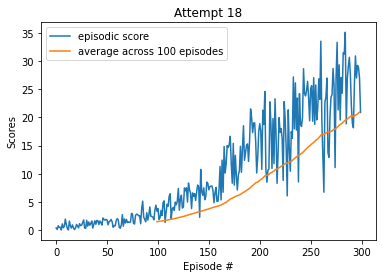

Episode 375	Average Score: 30.07
Environment solved in 275 episodes!	Average Score: 30.07


In [20]:
#  learn_updates=5, update_every=30, and increase a bit the learning rate, change the seed and use actor lr wit 5e-4
scores = ddpg(500, attempt=18)

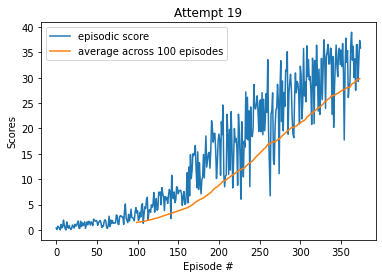

In [22]:
# The number was changed but it is the same as 18
plot_scores(scores, 19, 375)

In [23]:
env.close()

In [ ]:
# What if the learning rate is too low? 

In [16]:
# attempt 1 Actor and Critic with (128, 256) on first and second hidden layers respectively
# Update every episode
# Score finished at 2.23

In [17]:
# Second attempt: Augment hidden layers with one layer of size 128 on both networks for update every=10
# Scores finished at 4.45 


In [18]:
# Atempt 3. change update_every to 20


In [19]:
#Attempt 5: Back to the small architecture (64, 128, 64) , with gaussian noise.
#scores = ddpg(n_episodes=1000, max_t=1000)

In [20]:
#Update every 10 times and learn 10 times in a row sequentially
#Attempt 7

In [21]:
# Update every 20 times and learn 10 times in a row as suggested 
# benchmark implementation (64, 128, 128) on both networks with lr_actor at 5e-4 and eps 0.99, with replay buffer 2e5
# Also with 128 batch

Episode 100	Average Score: 3.02


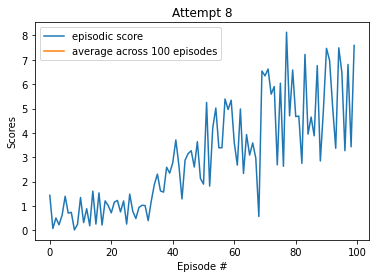

Episode 200	Average Score: 6.65


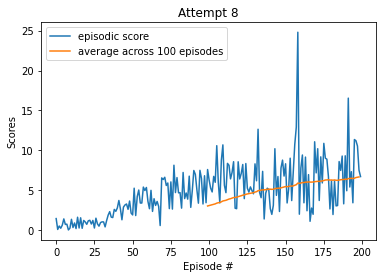

Episode 300	Average Score: 5.89


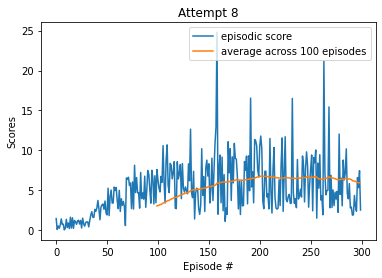

Episode 301	Average Score: 5.80

In [ ]:
scores = ddpg(n_episodes=500, attempt=8)

Episode 100	Average Score: 3.48


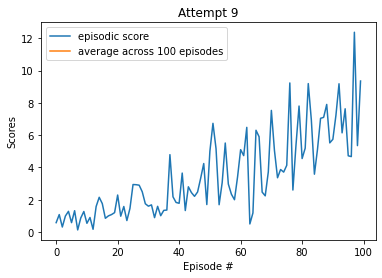

Episode 200	Average Score: 7.14


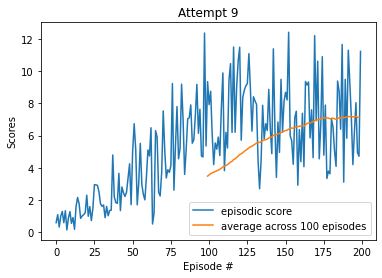

Episode 219	Average Score: 6.91

KeyboardInterrupt: 

In [23]:
# Attempt 9, change decay rate to be 0.999 
scores = ddpg(n_episodes=500, attempt=9)

Episode 100	Average Score: 4.37


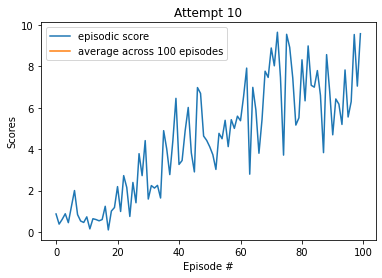

Episode 200	Average Score: 11.93


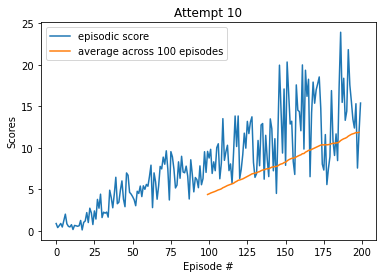

Episode 300	Average Score: 18.31


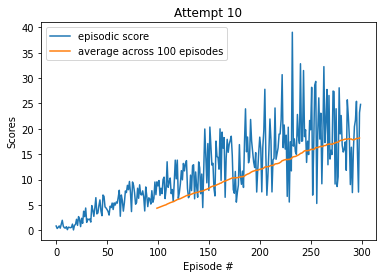

Episode 400	Average Score: 14.26


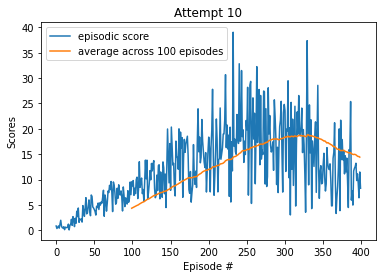

Episode 442	Average Score: 11.60

KeyboardInterrupt: 

In [22]:
# Attempt 9, keep decay rate  0.999, augment, and augment the layers to (128,256,128)
scores = ddpg(n_episodes=500, attempt=10)

Episode 100	Average Score: 1.28


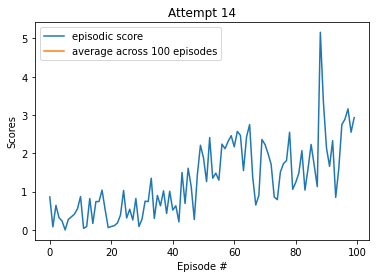

Episode 200	Average Score: 4.44


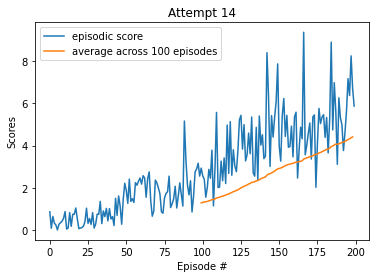

Episode 300	Average Score: 6.61


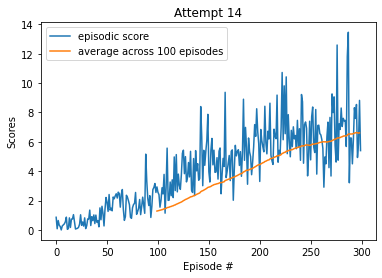

Episode 400	Average Score: 9.50


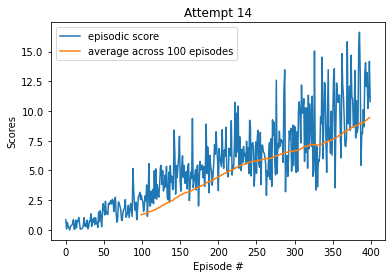

Episode 500	Average Score: 14.64


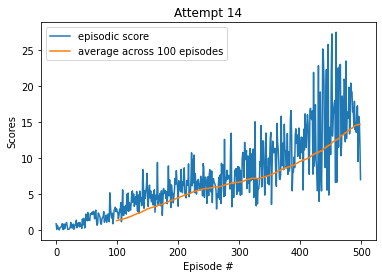

In [16]:
# Attempt 14 : Learn every 20 episodes for 5 updates with learning rates as in paper
scores = ddpg(n_episodes=500, attempt=14)

Episode 100	Average Score: 18.12


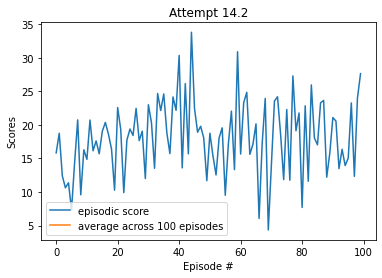

Episode 200	Average Score: 24.88


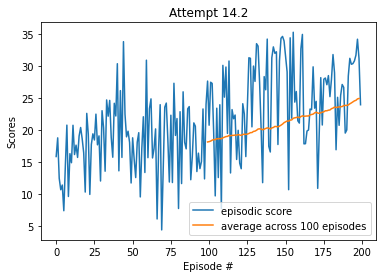

Episode 300	Average Score: 26.84


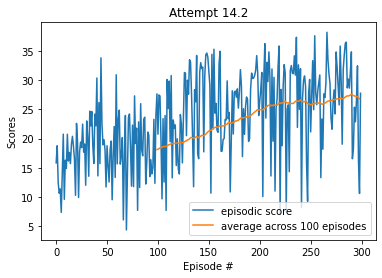

Episode 400	Average Score: 27.83


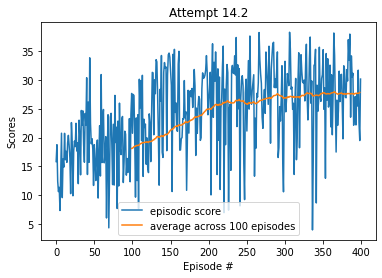

Episode 500	Average Score: 25.02


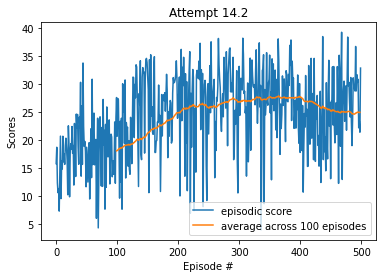

In [18]:
# Continue for another 500 episodes
scores_1 = ddpg(500, attempt=14.2)

In [ ]:
# There is a slight decrease in performance after the average arrives to ~28. 
# It is likely that the complexlity of the networks is enough, since the model
# is capable of attaining scores above 30. However, the learning is not stable, since
# There are several occurences of low scores (5-10) which are pushing the average down.
# In order to increase the stability, let us reduce the frequency of updates.


Episode 100	Average Score: 1.23


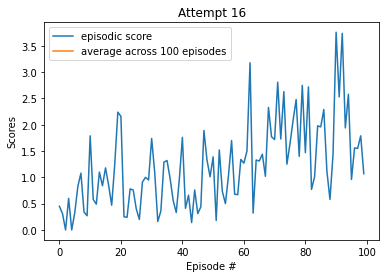

Episode 200	Average Score: 6.37


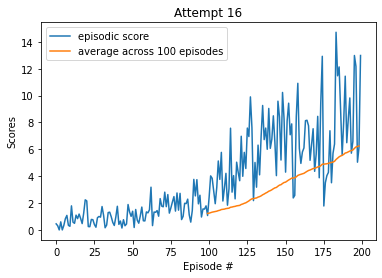

Episode 300	Average Score: 9.82


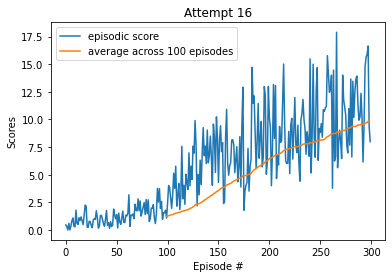

Episode 400	Average Score: 15.97


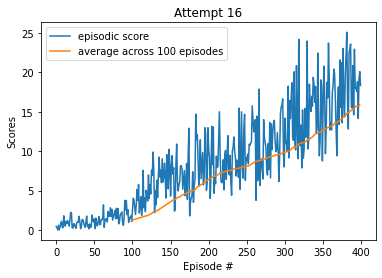

Episode 500	Average Score: 18.49


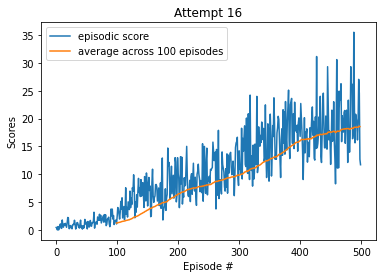

Episode 600	Average Score: 21.23


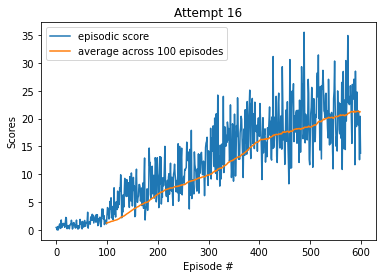

Episode 700	Average Score: 25.83


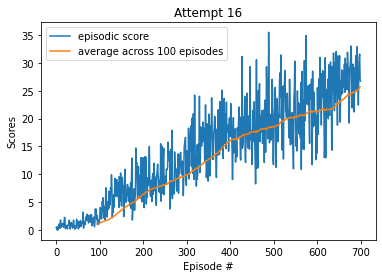

Episode 800	Average Score: 26.84


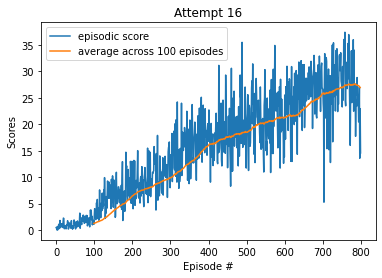

Episode 900	Average Score: 29.10


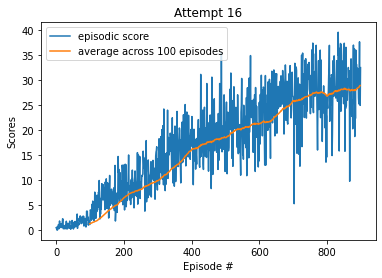

Episode 1000	Average Score: 26.89


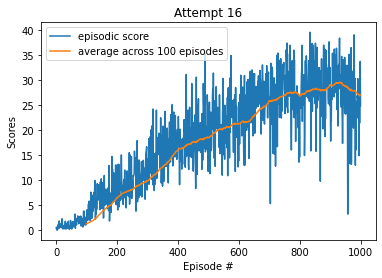

In [38]:
# Increase the gaps between training from 20 to 30
scores = ddpg(1000, attempt=16)

In [ ]:
# increase the update_learn from 5 to 10 and the buffer from 2 to 3

scores = ddpg(1000, attempt=18)

Episode 15	Average Score: 0.60

In [1]:
env.close()

NameError: name 'env' is not defined

In [ ]:
env.close()